# Импорт необходимых библиотек

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd 
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product

# Предобработка данных

Для выполнения задания возьмем датасет *FAANG Historical Stock Price Data* и изучим основную информацию о нем

In [2]:
df = pd.read_csv('Apple_Historical_StockPrice2.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,26.5000,26.547501,26.264999,26.297501,24.459534,77645600
1,2016-03-29,26.2225,26.947500,26.219999,26.920000,25.038527,124760400
2,2016-03-30,27.1625,27.605000,27.150000,27.389999,25.475679,182404400
3,2016-03-31,27.4300,27.475000,27.219999,27.247499,25.343138,103553600
4,2016-04-01,27.1950,27.500000,27.049999,27.497499,25.575666,103496000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [4]:
df.shape

(1260, 7)

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,56.476635,57.098048,55.860792,56.506099,55.358836,1.300474e+08
std,29.961638,30.397301,29.417572,29.916321,30.393892,5.867030e+07
min,22.500000,22.917500,22.367500,22.584999,21.134403,4.544800e+07
25%,37.451875,37.845625,37.139377,37.518126,35.840332,9.116405e+07
50%,46.306250,46.798750,45.942501,46.370001,44.998276,1.138023e+08
75%,66.016253,66.891874,65.626249,66.459377,65.805641,1.505391e+08
max,143.600006,145.089996,141.369995,143.160004,142.946396,4.584084e+08


Сгруппируем данные по месяцам, но прежде преведем столбец *Date* к правильному типу

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d %H:%M:%S')
df = df.sort_values(by='Date')
df = df.set_index('Date')

df = df.groupby(pd.Grouper(freq='M')).mean()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-03-31,26.828750,27.143750,26.713749,26.963750,25.079219,1.220910e+08
2016-04-30,26.696429,26.939762,26.463810,26.684762,24.819732,1.661683e+08
2016-05-31,23.739643,23.923690,23.512262,23.743690,22.199595,1.715565e+08
2016-06-30,24.147159,24.369432,23.992273,24.155568,22.604099,1.417269e+08
2016-07-31,24.612750,24.791000,24.500625,24.639125,23.056597,1.371559e+08


Посмотрим, как ведет себя линия тренда и остальное

<AxesSubplot:title={'center':'Residual'}, xlabel='Date'>

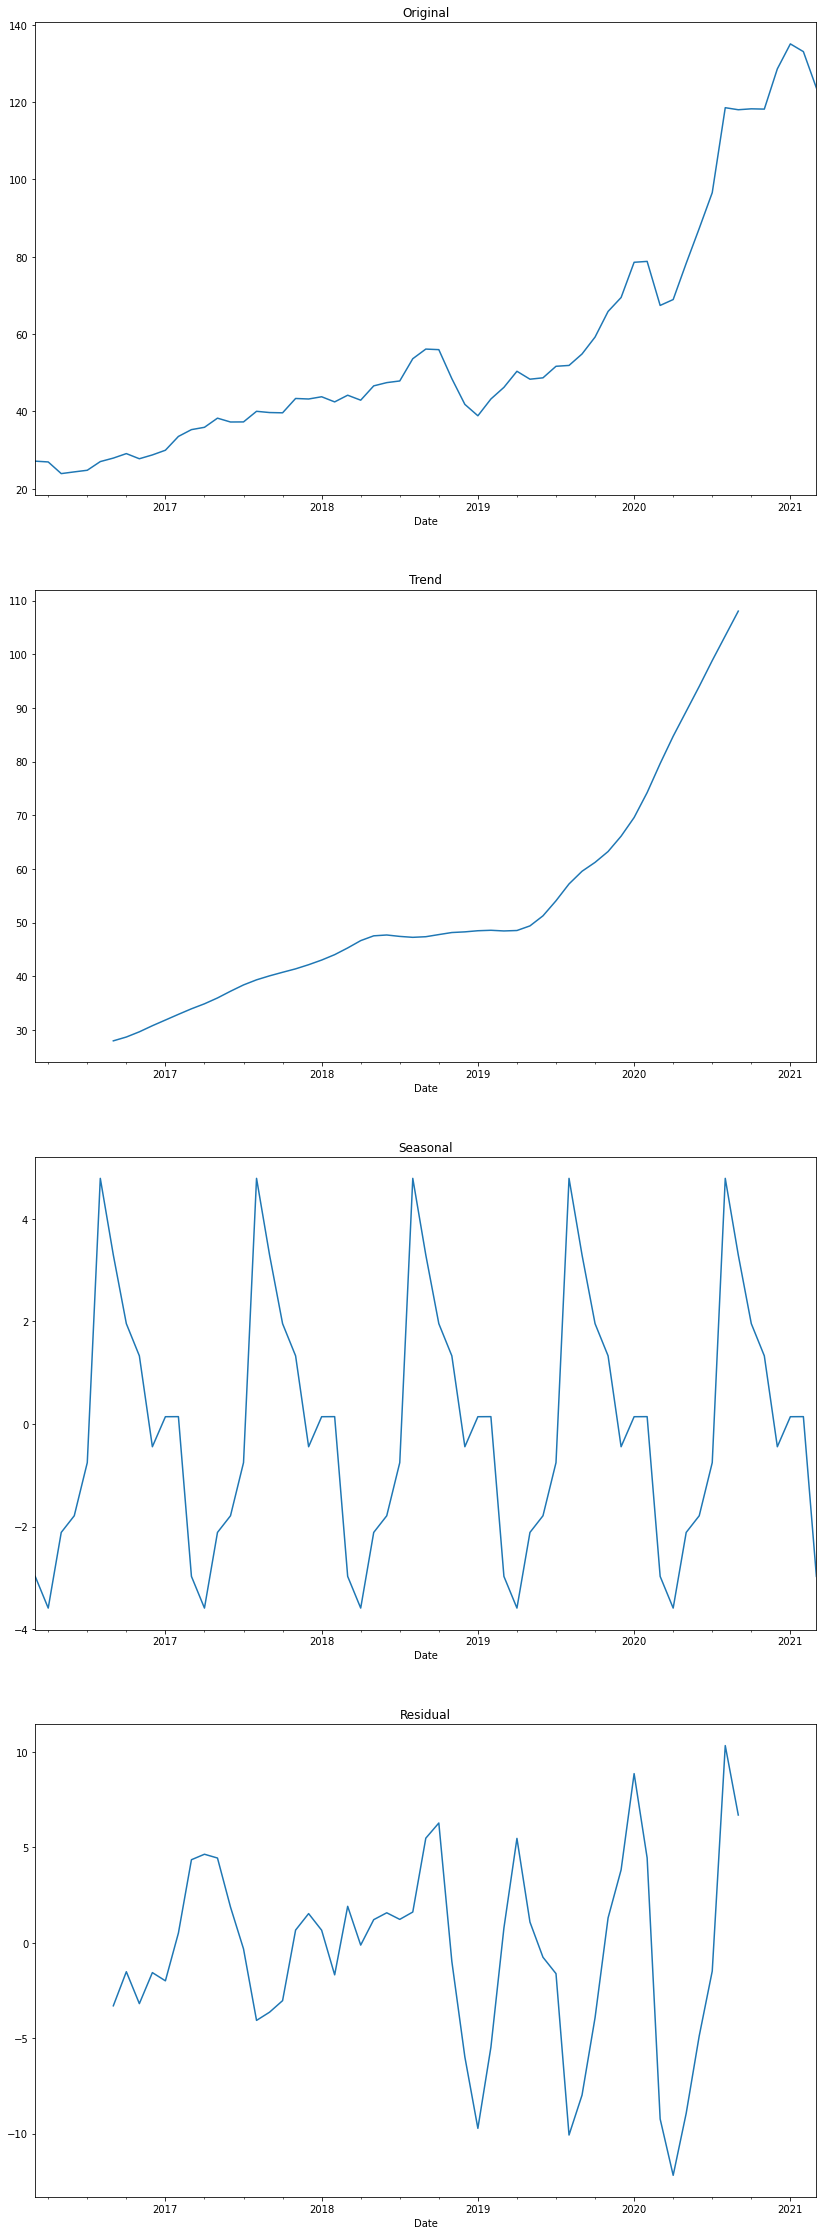

In [7]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df[['High']])

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3])

Наблюдается заметная линия тренда и сезонность, однако, чтоб убедиться в отсутствии стационарности, проведем тест Дики — Фуллера

Нулевая гипотеза: выборка нестационарна

Альтернативная гипотеза: выборка стационарна

In [8]:
p_value = adfuller(df['High'])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}')

if round(p_value, 4) > 0.05:
    print('Принимаем нулевую гипотезу, ряд нестационарен')
else:
    print('Принимаем альтернативную гипотезу, ряд стационарен')

Полученный уровень значимости (p-value): 0.951
Принимаем нулевую гипотезу, ряд нестационарен


Чтобы избавиться от тренда, логарифмируем данные

<AxesSubplot:xlabel='Date', ylabel='HighLog'>

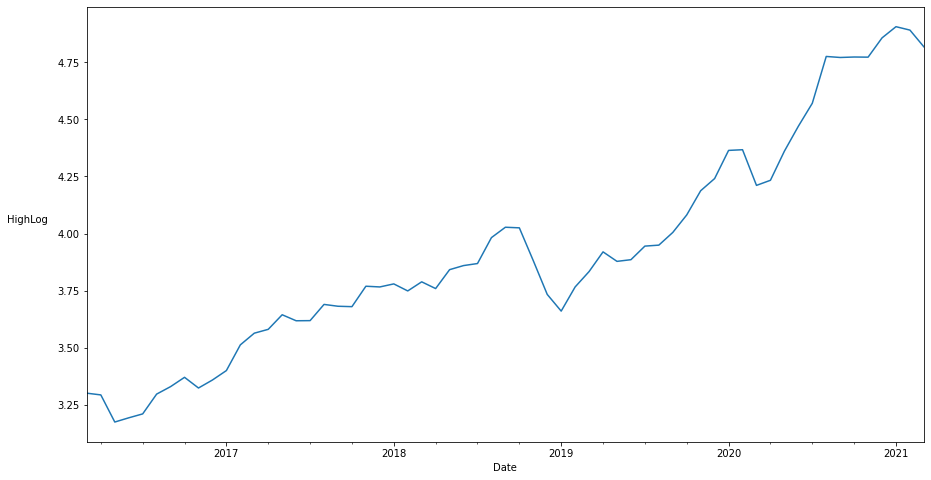

In [9]:
df['HighLog'] = np.log(df['High'])

plt.figure(figsize=(15, 8))
plt.ylabel('HighLog', rotation=0, labelpad=30)
df['HighLog'].plot()

А теперь продифференцируем времянной ряд и проверим его на стационарность

Полученный уровень значимости (p-value): 0.0
Принимаем альтернативную гипотезу, ряд стационарен


<AxesSubplot:xlabel='Date', ylabel='HighLogSDiff'>

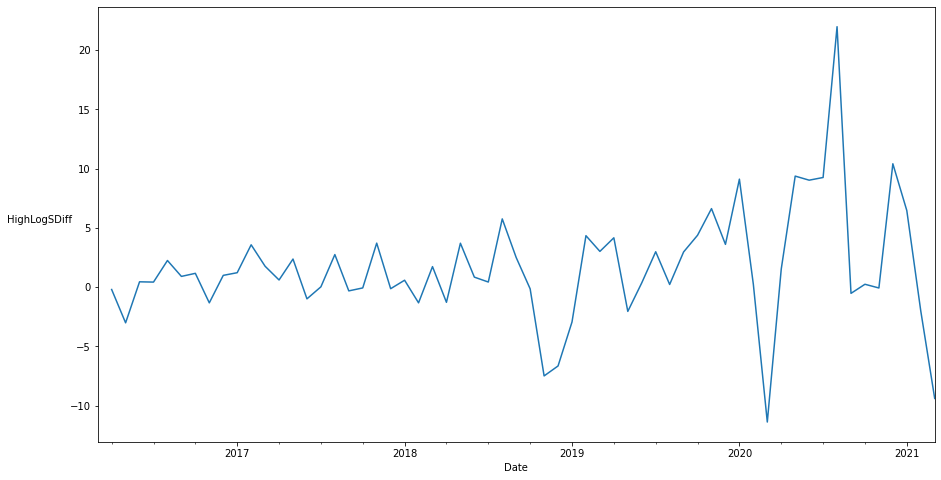

In [10]:
df['HighLogSDiff'] = df['High'].diff(1) 
p_value = adfuller(df["HighLogSDiff"][1:])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}')

if round(p_value, 4) > 0.05:
    print('Принимаем нулевую гипотезу, ряд нестационарен')
else:
    print('Принимаем альтернативную гипотезу, ряд стационарен')

plt.figure(figsize=(15, 8))
plt.ylabel('HighLogSDiff', rotation=0, labelpad=30)
df['HighLogSDiff'].plot()

Таким образом, добились стационарности ряда, то есть избавились от тренда и сезонности

Построим коррелограммы

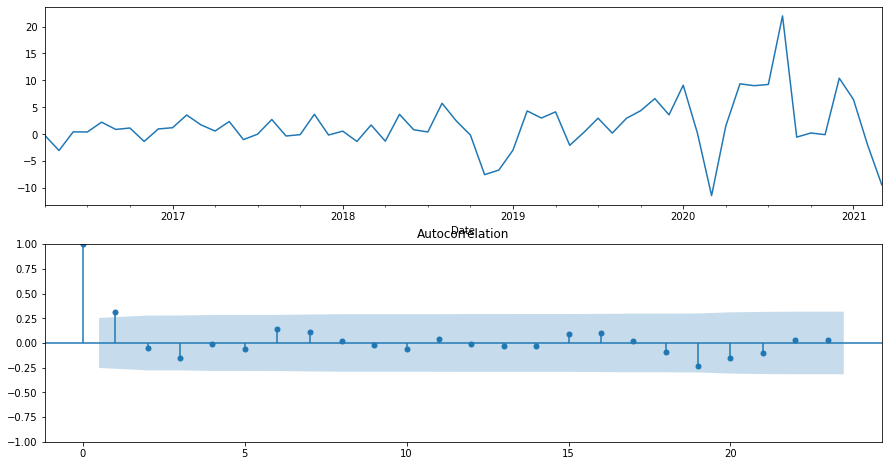

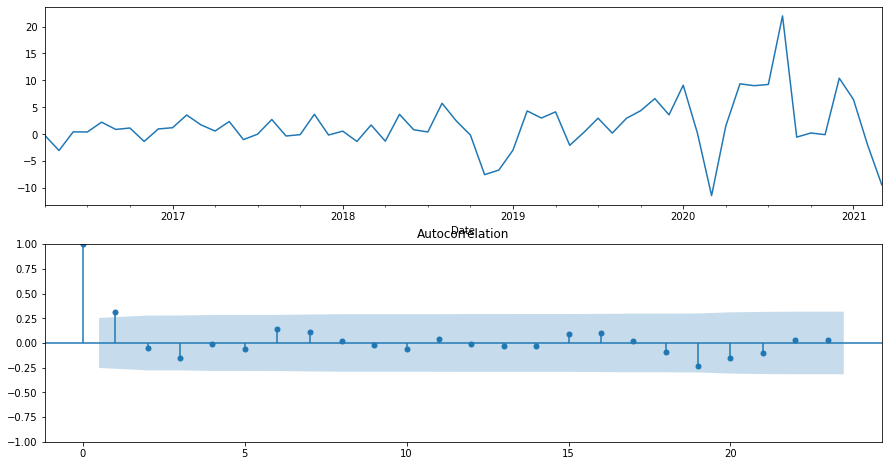

In [11]:
plt.figure(figsize=(15, 8))

ax = plt.subplot(211)
df['HighLogSDiff'][1:].plot(ax=ax)

ax = plt.subplot(212)
plot_acf(df['HighLogSDiff'][1:], lags=23, ax=ax)

# Обучение модели

In [12]:
d=1
D=range(0,2)

qs = range(1, 4)
Qs = range(1, 3)

ps = range(1, 4)
Ps = range(3, 5)


size = len(df.HighLog)
percentile = int(0.8 * size)

X_train = df['HighLog'][:percentile]
X_test = df['HighLog'][percentile:]
y_train = df['High'][:percentile]
y_test = df['High'][percentile:]

parameters = product(ps, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [13]:
%%time

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            X_train, 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], param[3], param[4], 6)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

  0%|                                                    | 0/72 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  1%|▌                                           | 1/72 [00:00<00:26,  2.67it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  3%|█▏                                          | 2/72 [00:00<00:26,  2.64it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 35%|██████████████▉                            | 25/72 [00:15<00:34,  1.35it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 36%|███████████████▌                           | 26/72 [00:16<00:31,  1.47it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 38%|████████████████▏                          | 27/72 [00:16<00:30,  1.46it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 68%|█████████████████████████████▎             | 49/72 [00:35<00:18,  1.22it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 69%|█████████████████████████████▊             | 50/72 [00:36<00:16,  1.35it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 71%|██████████████████████████████▍            | 51/72 [00:36<00:14,  1.41it/s]/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

CPU times: user 3min 3s, sys: 30.6 s, total: 3min 33s
Wall time: 54.2 s


In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

         parameters         aic
0   (1, 1, 3, 0, 1) -125.757422
8   (1, 2, 3, 0, 1) -125.555751
32  (2, 2, 3, 0, 1) -124.532045
36  (2, 2, 4, 0, 1) -124.372191
56  (3, 2, 3, 0, 1) -124.370812


Информация о лучшей модели

In [15]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           HighLog   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(3, 0, 1, 6)   Log Likelihood                  69.879
Date:                           Sun, 20 Feb 2022   AIC                           -125.757
Time:                                   23:51:38   BIC                           -112.806
Sample:                               03-31-2016   HQIC                          -120.884
                                    - 02-29-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4651      0.471      0.987      0.323      -0.458       1.388
ma.L1         -0.1100      0.471     -0.234

Графики отклонений и автокорреляции по лучшей модели

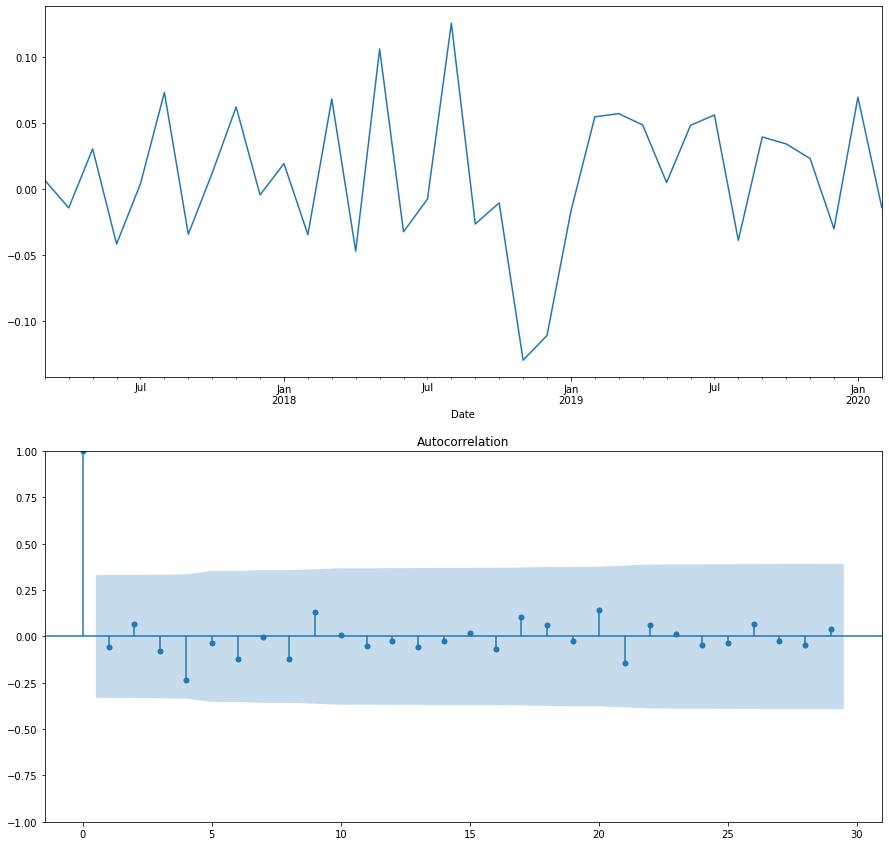

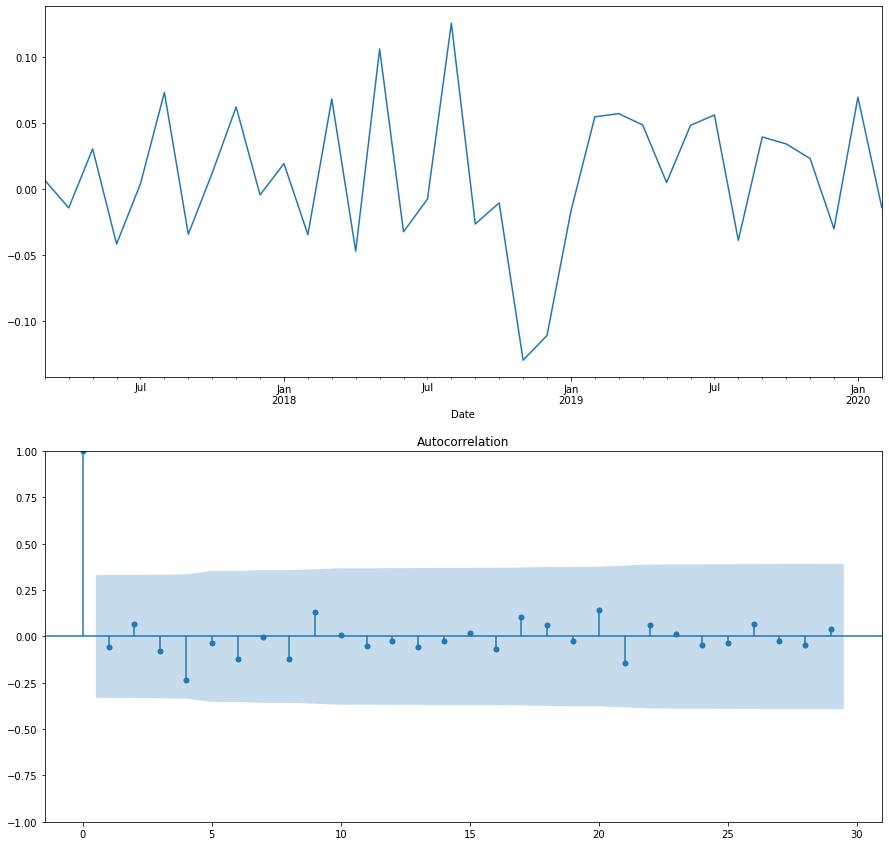

In [16]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[12:].plot()

ax = plt.subplot(212)
plot_acf(best_model.resid[13:].values.squeeze(), lags=29, ax=ax)

График результата на тренировочной выборке

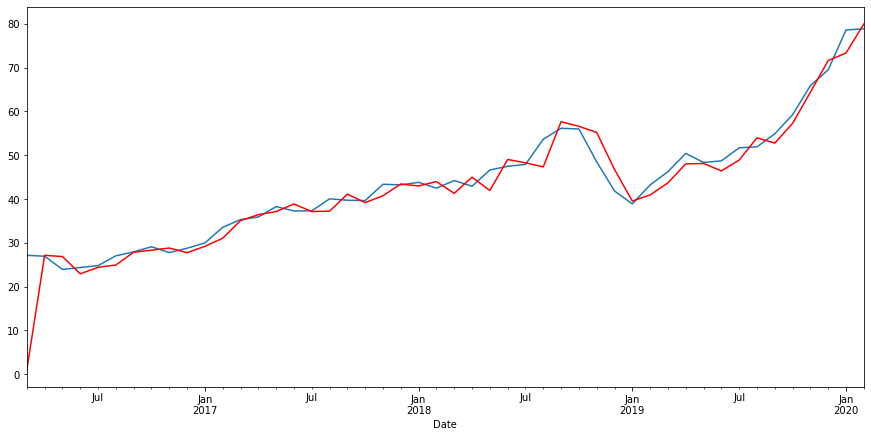

In [17]:
y_train_pred = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

y_train.plot()
y_train_pred.plot(c='r');

Создадим датафрейм, куда будем записывать данные, полученные с предсказаний

In [18]:
predict_len = size - percentile
df['Model'] = np.exp(best_model.fittedvalues)

new_close_value = df[['High', 'Model']]
                     
future_date = [
    datetime.datetime.strptime("2019-12", "%Y-%m") + relativedelta(months=x)
    for x in range(0, predict_len)
]

future_df = pd.DataFrame(index=future_date, columns=['Value', 'Model'])
new_close_value = pd.concat([new_close_value, future_df])

print(new_close_value.shape)
new_close_value.tail()

(74, 3)


,High,Model,Value
2020-08-01,NaN,NaN,NaN
2020-09-01,NaN,NaN,NaN
2020-10-01,NaN,NaN,NaN
2020-11-01,NaN,NaN,NaN
2020-12-01,NaN,NaN,NaN


Продолжим предсказывать на тестовой выборке

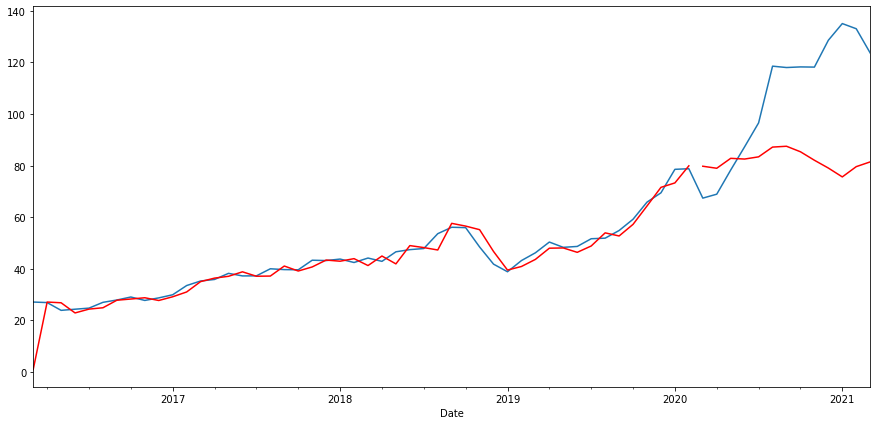

In [19]:
y_pred = np.exp(best_model.predict(start=percentile, end=percentile + predict_len - 1))

plt.figure(figsize=(15,7))
df['High'].plot()
y_pred.plot(c='r')

y_train_pred.plot(c='r');

<AxesSubplot:xlabel='Date'>

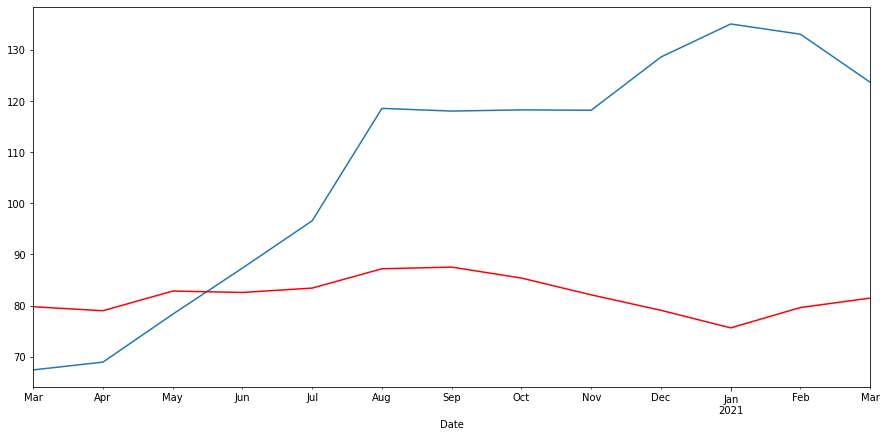

In [20]:
plt.figure(figsize=(15,7))
y_test.plot()
y_pred.plot(c='r')

# Расчет MAPE

In [21]:
print(mean_absolute_percentage_error(y_pred, y_test))

0.360515143310432
